In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
fs=4000

In [3]:
import glob
path = '../input/emg2channels'

In [4]:
label=['HC','II','LL','MM','RR','TI','TL','TM','TR','TT']
datanumber=[0,0,0,0,0,0,0,0,0,0]

In [5]:
# N = 200
# for num in range(1,11):
#     all_files = glob.glob(path+'/EMG-S'+str(num)+'/'+'*.csv')
#     dflist=[]
#     for ii in range(len(all_files)):
#         dflist.append(pd.read_csv(all_files[ii],header=None))    
#     randfileindex = np.random.randint(0, len(all_files)-1, N)
#     randsignaldex = np.random.randint(0, len(dflist[0])-1.5*fs-1, N)
#     randsignallen = np.random.randint(0.5*fs,1.5*fs,N)
#     dfsignal = pd.DataFrame(columns = [0, 1, 'class'])
#     for ii in range(N):
#         fileindx = randfileindex[ii]
# #         print(num,ii)
#         file=''.join(''.join(all_files[fileindx].split('/')[3:5]).split('.')[0].split('-')[1:3])
#         if len(file)==6:
#             labelpos=label.index(file[3:5])
#         else:
#             labelpos=label.index(file[2:4])
#         df = dflist[randfileindex[ii]]
#         indx = pd.Index(range(randsignaldex[ii],randsignaldex[ii]+randsignallen[ii]))
#         tmp = df.iloc[indx].reset_index(drop=True)
#         d = pd.DataFrame(int(labelpos)*np.ones((len(tmp),)))
#         d.columns = ['class']
#         tmp = tmp.merge(d,left_index=True, right_index=True)
#     #     print(tmp.head())
#         dfsignal = dfsignal.append(tmp)
#     dfsignal = dfsignal.reset_index(drop=True)
#     dfsignal.to_csv('testsignal'+str(num)+'.csv')

In [6]:
df = []
for ii in range (10):
    df.append(pd.read_csv('/kaggle/input/test-signal-results-s10/testsignal'+str(ii+1)+'.csv'))

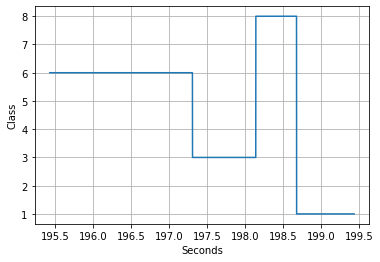

In [7]:
import matplotlib.pyplot as plt
dfsignal = df[0]
# dfsignal.plot( y=['class'])
t = (1/fs)*np.array(range(len(dfsignal)))
y = np.array(dfsignal['class'])
plt.plot(t[len(dfsignal)-16000:len(dfsignal)],y[len(dfsignal)-16000:len(dfsignal)])
# plt.plot(t,y)
plt.xlabel('Seconds')
plt.ylabel('Class')
plt.grid()

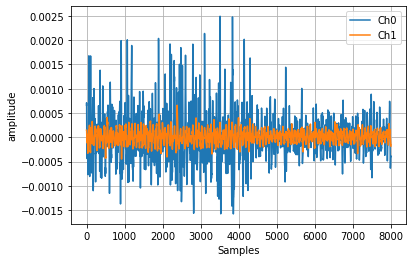

In [8]:
t = (1/fs)*np.array(range(len(dfsignal)))
y = np.array(dfsignal['0'])
plt.plot(y[0:2*fs],label = 'Ch0')
y = np.array(dfsignal['1'])
plt.plot(y[0:2*fs],label = 'Ch1')
# plt.xlabel('Seconds')
plt.xlabel('Samples')
plt.ylabel('amplitude')
plt.legend()
plt.grid()
plt.show()

In [9]:
import fastai
fastai.__version__

'2.3.0'

In [10]:
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback

In [11]:
from scipy import signal
from PIL import Image
from IPython.display import clear_output
learner = load_learner('/kaggle/input/resnet34-model-02-and-10-second/02_model.pkl')
pred = []
df0=np.array(dfsignal['0'])
df1=np.array(dfsignal['1'])
dfcl = np.array(dfsignal['class'])
max = 60
for ii in range(0,20*fs,100):
# for ii in range(len(df0)-fs-16000,len(df0)-fs,1000):
# for ii in range(5000,5001):
    f, t, Zxx = signal.stft(df0[ii:ii+2*fs//10], fs, boundary = None, nperseg=int(fs/10))    
#     f, t, Zxx = signal.stft(df0[ii:ii+fs], fs, nperseg=int(fs/10))
    data0=20*np.log10(np.abs(Zxx))
    f, t, Zxx = signal.stft(df1[ii:ii+2*fs//10], fs, boundary = None, nperseg=int(fs/10))
#     f, t, Zxx = signal.stft(df1[ii:ii+fs], fs, nperseg=int(fs/10))
    data1=20*np.log10(np.abs(Zxx))
    data01=np.concatenate((data0[0:60,:],data1[0:60,:]),axis=1)
    datamin=data01.min()
    datamax=data01.max()
    data01 = data01-datamax
    data01 = np.where(data01<-max, -max,data01)
    data01 = np.uint8((data01+max)*255//max)
    im = Image.fromarray(data01)
    im = PILImage(im)
    pred_class,pred_idx,outputs = learner.predict(im)
    clear_output(wait=True)
    pred.append([ii,dfsignal['class'].iloc[ii],pred_class])
# plt.imshow(data01,cmap='gray', vmin=0, vmax=255)

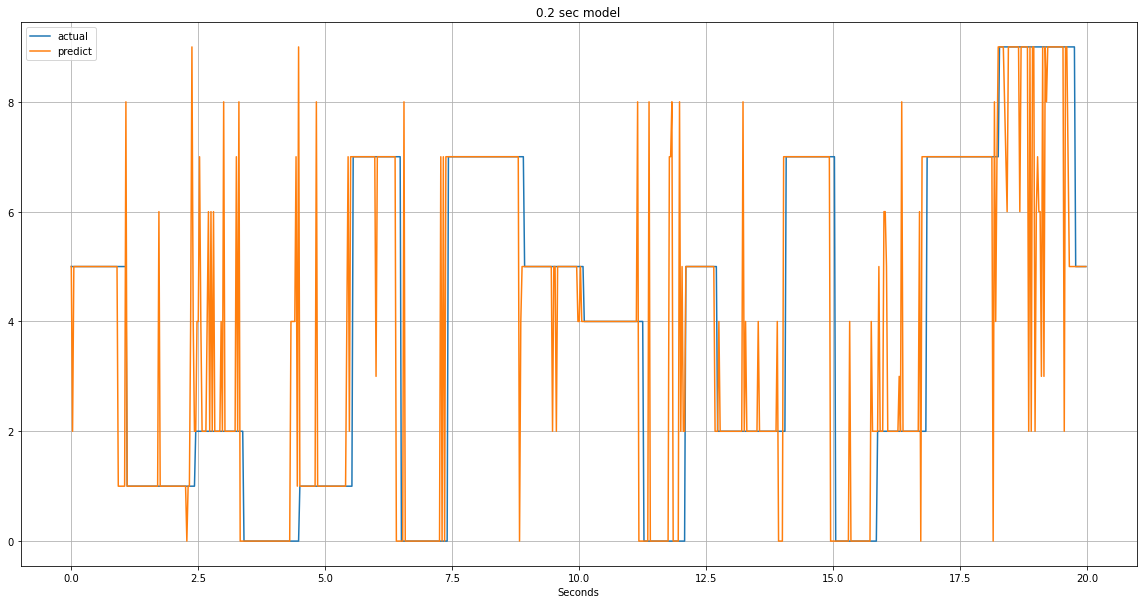

In [12]:
df = pd.DataFrame(pred)
x = np.array(df[0])
y0 = np.array(df[1]).astype(int)
y1 = np.array(df[2]).astype(int)
plt.figure(figsize=(20, 10))
x = x/fs
plt.plot(x,y0,label ='actual')
plt.plot(x,y1,label ='predict')
plt.xlabel('Seconds')
plt.title('0.2 sec model')
plt.legend()
plt.grid()
plt.show()

In [13]:
from scipy import signal
from PIL import Image
from IPython.display import clear_output
learner = load_learner('/kaggle/input/resnet34-model-02-and-10-second/10_model.pkl')
pred = []
df0=np.array(dfsignal['0'])
df1=np.array(dfsignal['1'])
dfcl = np.array(dfsignal['class'])
max = 60
for ii in range(0,20*fs,100):
# for ii in range(len(df0)-fs-16000,len(df0)-fs,1000):
# for ii in range(5000,5001):
#     f, t, Zxx = signal.stft(df0[ii:ii+2*fs//10], fs, boundary = None, nperseg=int(fs/10))    
    f, t, Zxx = signal.stft(df0[ii:ii+fs], fs, boundary = None, nperseg=int(fs/10))
    data0=20*np.log10(np.abs(Zxx))
#     f, t, Zxx = signal.stft(df1[ii:ii+2*fs//10], fs, boundary = None, nperseg=int(fs/10))
    f, t, Zxx = signal.stft(df1[ii:ii+fs], fs, boundary = None, nperseg=int(fs/10))
    data1=20*np.log10(np.abs(Zxx))
    data01=np.concatenate((data0[0:60,:],data1[0:60,:]),axis=1)
    datamin=data01.min()
    datamax=data01.max()
    data01 = data01-datamax
    data01 = np.where(data01<-max, -max,data01)
    data01 = np.uint8((data01+max)*255//max)
    im = Image.fromarray(data01)
    im = PILImage(im)
    pred_class,pred_idx,outputs = learner.predict(im)
    clear_output(wait=True)
    pred.append([ii,dfsignal['class'].iloc[ii],pred_class])
# plt.imshow(data01,cmap='gray', vmin=0, vmax=255)

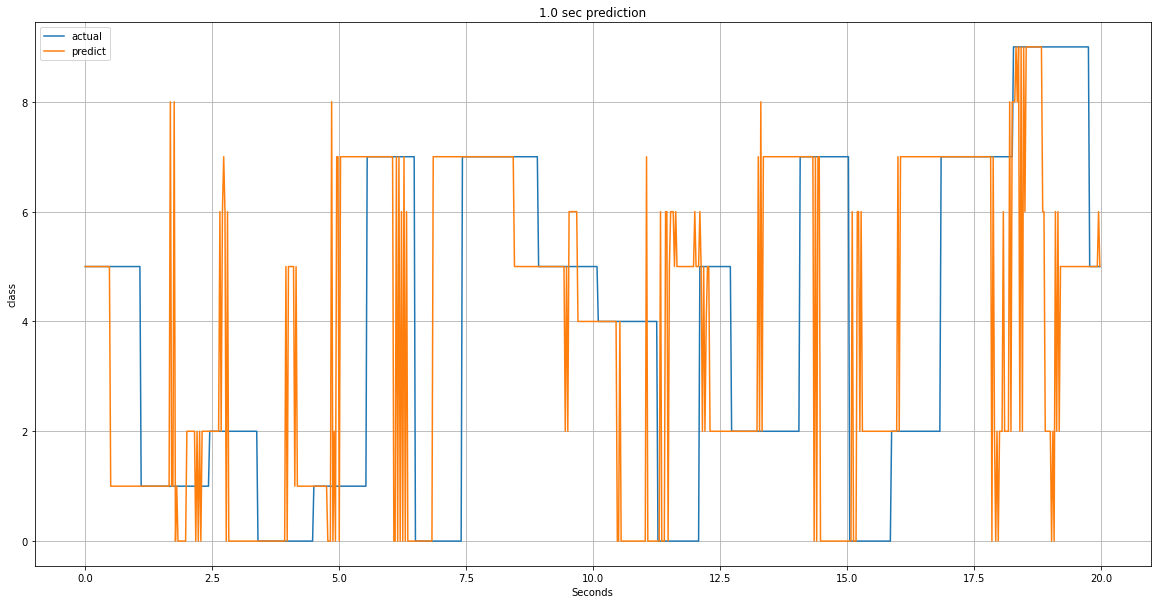

In [14]:
df = pd.DataFrame(pred)
x = np.array(df[0])
y0 = np.array(df[1]).astype(int)
y1 = np.array(df[2]).astype(int)
plt.figure(figsize=(20, 10))
x = x/fs
plt.plot(x,y0,label ='actual')
plt.plot(x,y1,label ='predict')
plt.xlabel('Seconds')
plt.ylabel('class')
plt.title('1.0 sec prediction')
plt.legend()
plt.grid()
plt.show()